# MA214 Group Assignment Code

Registration numbers: 
2312042, 2315586, 2318265, 2316207, 2316982, 2312554

*Reference list can be found at the bottom of the file*

**1. Import Packages**

In [8]:
# Import packages
import pandas as pd # Used for loading in our dataset
from scipy.stats.mstats import winsorize # Used to winsorize the centality measures [42].
import seaborn as sns # Used to add aesthetics to graphs such as the barplot 
import sys # Used to adjust adjacency matrix to allow us to see the full size [44].
import networkx as nx # Used frequently throughout the whole code so we could analyse our network [43].
import matplotlib.pyplot as plt # Used to plot graphs such as the histogram for centrality measures [45].
import numpy as np # We used numpy frequently for statistical calculations [40].
import networkx.algorithms.community as nx_comm # To find the modularity of our network from MA214 PGT lab 2
from mpl_toolkits.basemap import Basemap as Basemap # This was used to create a map of Chile [41].
import matplotlib.patches as mpatches # This was used to display a legend on the map of Chile [46].
import statistics as st # For clustering coefficient statistics


**2. File directory**

*Set directory*

In [9]:
# READ IN THE DATA

# These are nodes
power_nodes = pd.read_csv('/Documents/Chilean_PowerGrid_Data/WithTap_node.csv')

# These are edges
edges = pd.read_csv('/Documents/Chilean_PowerGrid_Data/WithTap_edge.csv')

**3. Checking Data**

In [10]:
# Checking data
# Using head function to view the first 5 rows in each dataset.
print(power_nodes.head())
print(edges.head())

   Id           Label                  Owner        Role  Longitude  \
0   1      San Javier               Transnet  Substation -71.711721   
1   2    Constitucion               Transnet  Substation -72.402716   
2   3          Paposo              Transelec      Switch -69.943670   
3   4  Tap Off Taltal  Electrica Panguipulli      Switch -69.943670   
4   5   Eolica Taltal             P.E Taltal       Plant -69.848464   

    Latitude        ref  
0 -35.588740   original  
1 -35.363701   original  
2 -25.730608  converted  
3 -25.730608  converted  
4 -25.059477   original  
   Source  Target        Type  Distance  Voltage  Lines
0       1       2  Undirected     75.13       66      1
1       3       4  Undirected     20.00      220      2
2       4       5  Undirected     43.00      220      1
3       4       6  Undirected    165.00      220      2
4       6       7  Undirected      0.00      110      1


**4. NETWORK MAP OVERLAYING CHILE**

*REFERENCED FROM MA214-LAB-2 AND [34][39]*

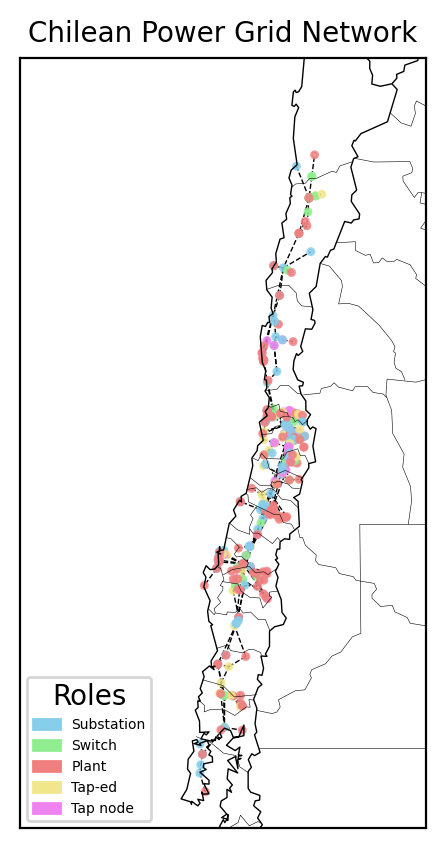

In [11]:
# Chilean Power grid network map

# Create Graph from the edges CSV, using "Source" & "Target" to direct edges, and assigning each edge "Voltage".
G = nx.from_pandas_edgelist(edges, source = 'Source', target = 'Target',
                                 edge_attr = 'Voltage', create_using = nx.Graph())

# Set Figure and DPI to suitable size for Visualisation
plt.figure(figsize=(15, 5), dpi = 200)

# Plotting coordinates to show a map of Chile.
m = Basemap(
         projection='merc',
      llcrnrlon=-80.0,
    llcrnrlat=-44.0,
    urcrnrlon=-66.0,
    urcrnrlat=-22.0,
         lat_ts=0,
         resolution='l',
         suppress_ticks=True)

# Assigning a colour code to each node role.
roles = power_nodes['Role'].unique()
role_colours = {'Substation':'skyblue', 'Switch':'lightgreen', 'Plant':'lightcoral', 'Tap-ed':'khaki', 'Tap node':'violet'}
node_colors = [role_colours[role] for role in power_nodes['Role']]

# Apply Basemap to the Longutude and latitude series, which as a tuple are then placed as a value in a dict with
# the power_nodes['Id'] column as the key.
mx, my = m(power_nodes['Longitude'], power_nodes['Latitude'])
pos = dict(zip(power_nodes['Id'], zip(mx, my)))


# Draw the Network. 
# I have colour coded the nodes depending on their role. Which will be shown via a legend.
nx.draw_networkx_nodes(G, pos=pos, nodelist=power_nodes['Id'], node_color=node_colors, 
                       node_size=5, alpha = 0.8)


# Drawing the network edges. I have changed the style of the edges for dotted lines.
nx.draw_networkx_edges(G, pos=pos, edge_color= 'Black', width=0.5, style = '--')

# Adding legend to display different node roles.
legend_labels = {role: mpatches.Patch(color=role_colours[role], label=role) for role in roles}
plt.legend(handles=list(legend_labels.values()), loc='lower left', title='Roles', fontsize= 5)

# Add the Underlying Chile Map
m.drawcountries(linewidth = 0.5) # Adjusting line width between countries 
m.drawstates(linewidth = 0.2) # Adjusting line width for locations within the country
m.drawcoastlines(linewidth=0.5) # Adjusting line width for coastlines

plt.title('Chilean Power Grid Network', fontsize = 10) # Plotting title
plt.savefig('Network_map.png', bbox_inches='tight', pad_inches=0.1) # Saving figure for analysis
plt.show() # Showing plot below

# Basemap code from [34].
# mpatches legend code from [39].

**5. CENTRAL CHILEAN POWER GRID**

*REFERENCED FROM LAB 2 AND BELOW*

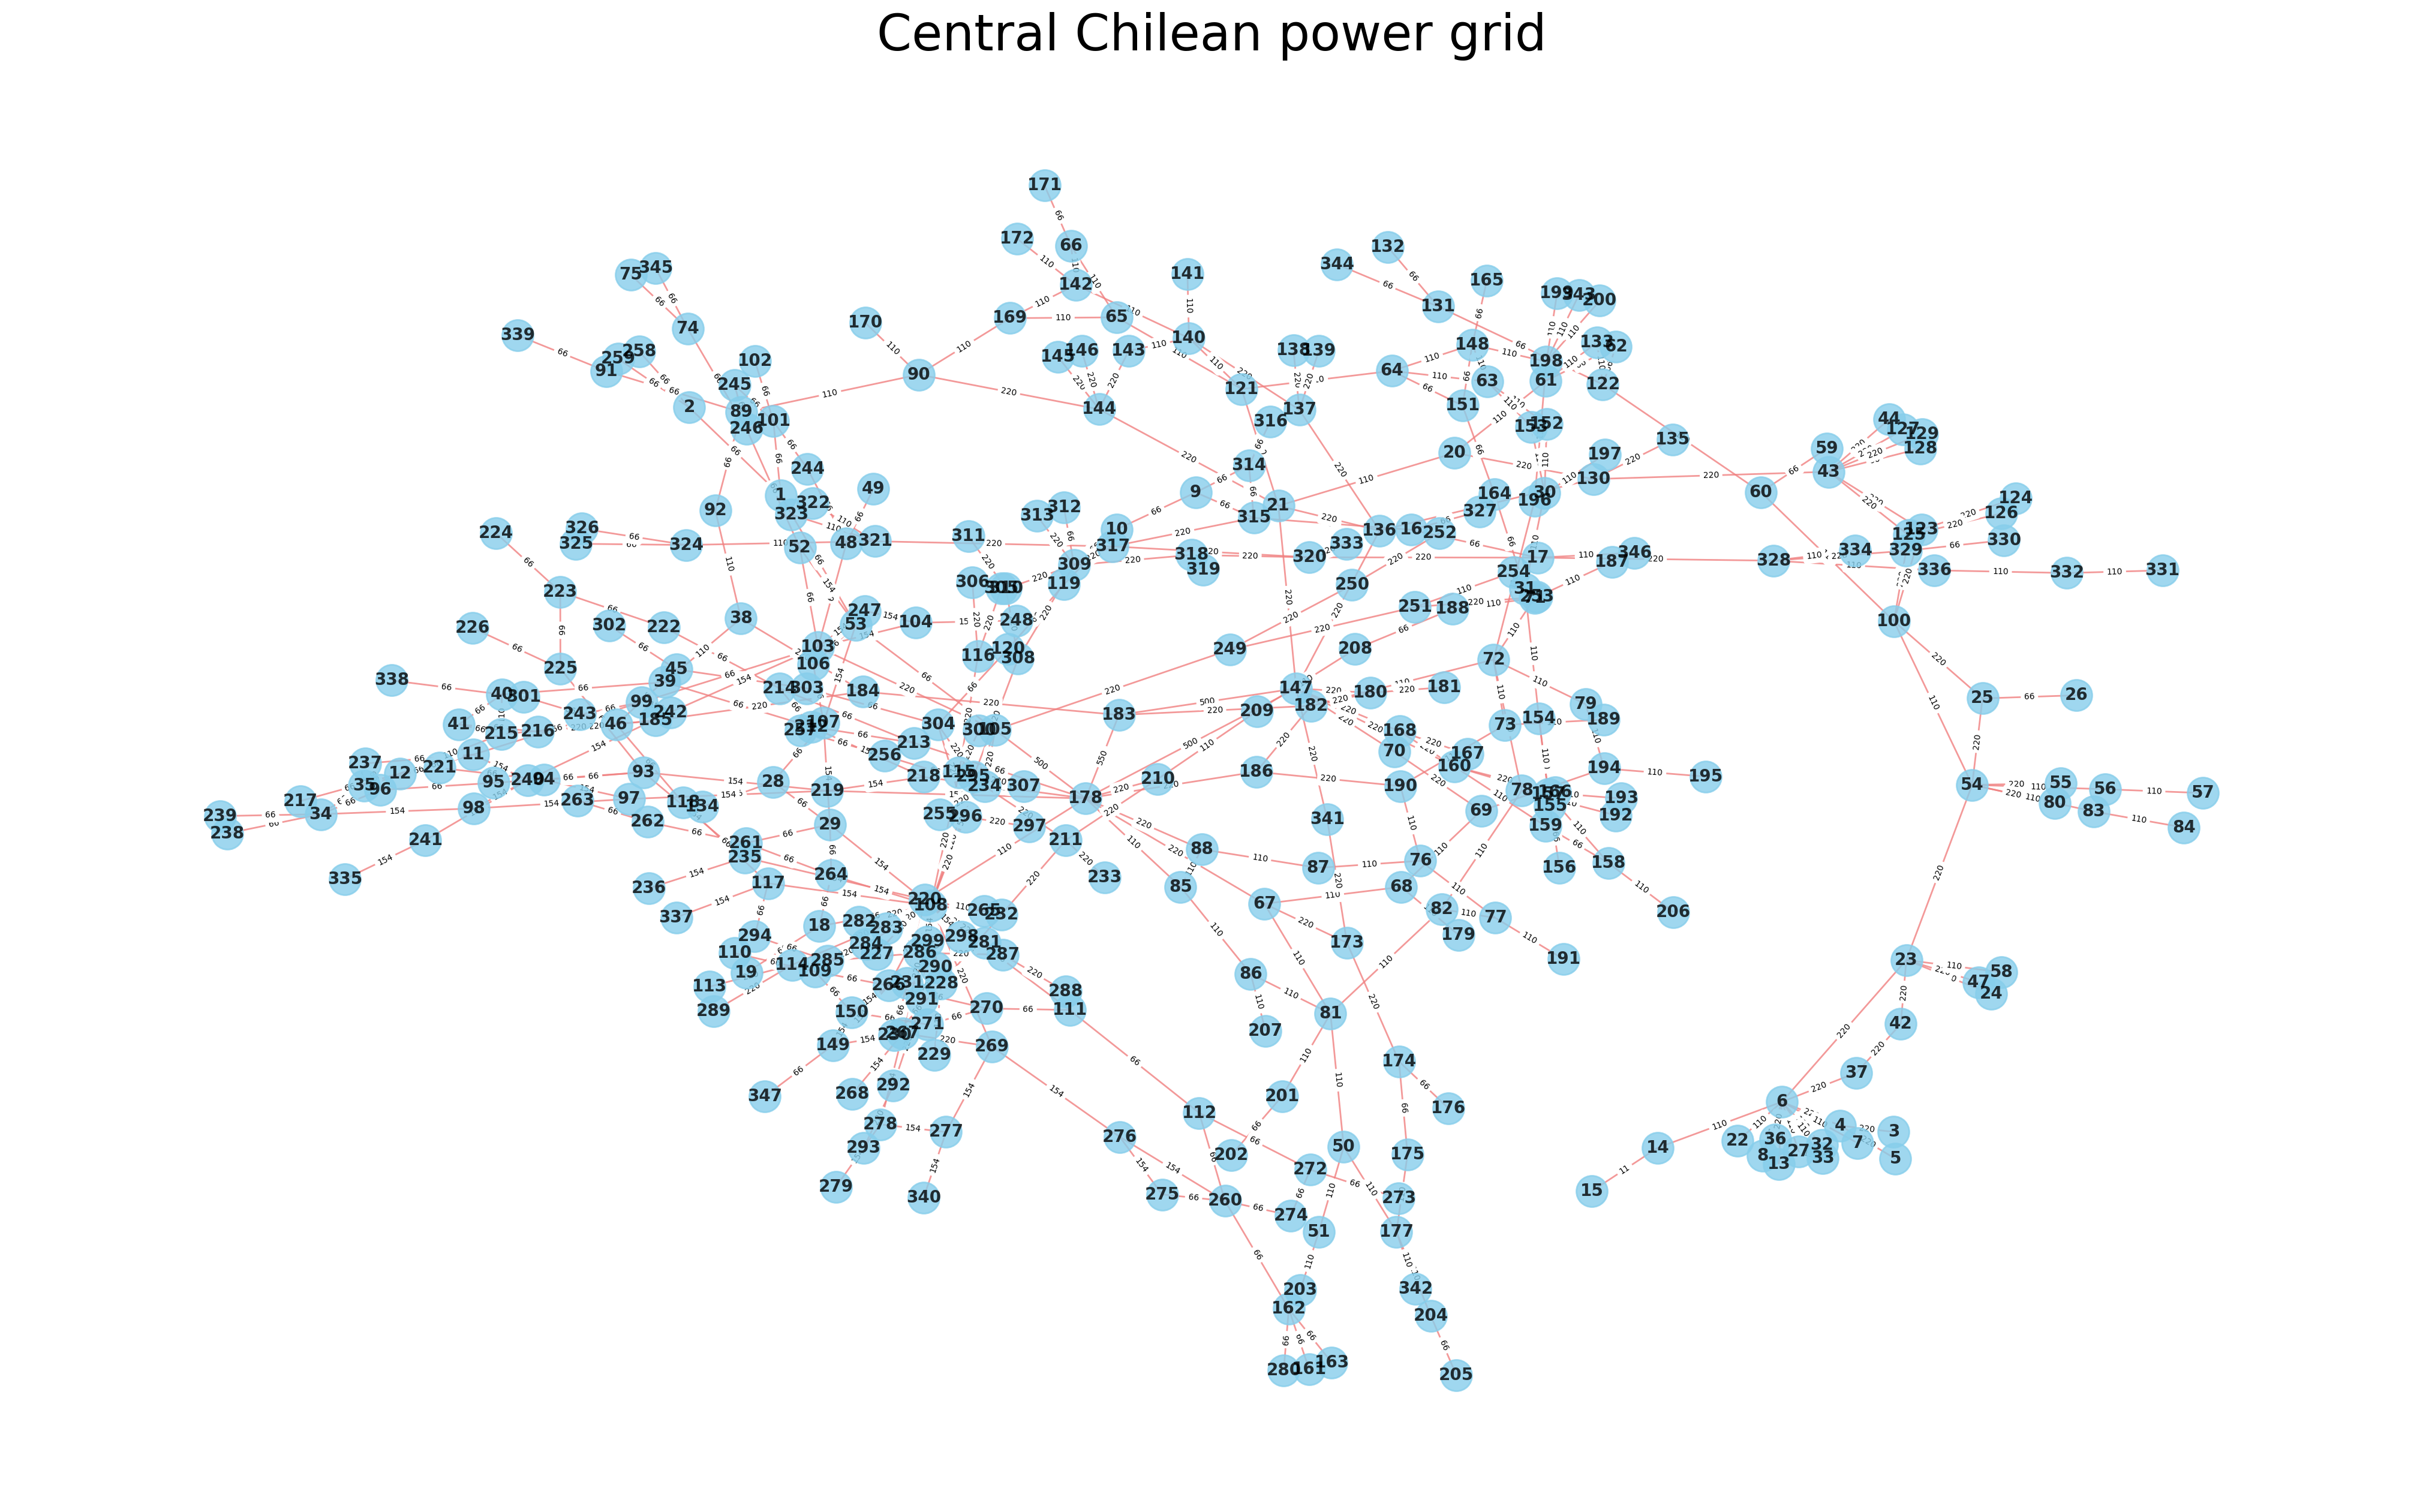

In [12]:
# Produces Central Chilean Power Grid

# Set Figure size and resolution
plt.figure(figsize=(20,12), dpi=200)
# Create a Blank Graph.
PowerGrid = nx.Graph()

# Using the fn add_nodes_from(), add nodes for the power_nodes['Id'] column. The PID of the Dataset.
PowerGrid.add_nodes_from(power_nodes['Id'])

# Add edges from branch to target, set voltage values on the edges
PowerGrid.add_edges_from([(edges['Source'], edges['Target'], {'voltage': edges['Voltage']}) for idx, edges in edges.iterrows()])

# Set New Layout
pos = nx.spring_layout(PowerGrid)

# Draw graph and set font weights, size and aesthetics
nx.draw(PowerGrid, pos, with_labels = True, font_weight = 'bold', node_size = 350, font_size = 10, node_color = 'skyblue', alpha = 0.8, edge_color='lightcoral')

# Isolate Voltage and draw as an edge label
edge_labels = nx.get_edge_attributes(PowerGrid, 'voltage')
nx.draw_networkx_edge_labels(PowerGrid, pos, edge_labels=edge_labels, font_size=5)

plt.title('Central Chilean power grid', fontsize = 30) # Plotting title

plt.savefig('Central_Chilean_PowerGrid.png', bbox_inches='tight') # Saving figure for analysis

plt.show() # Shows the plot

**6. CONFIRM NUMBER OF NODES ASSIGNED TO EACH ROLE (PLANT, SUBSTATION, TAP-ED, TAP NODE, SWITCH)**

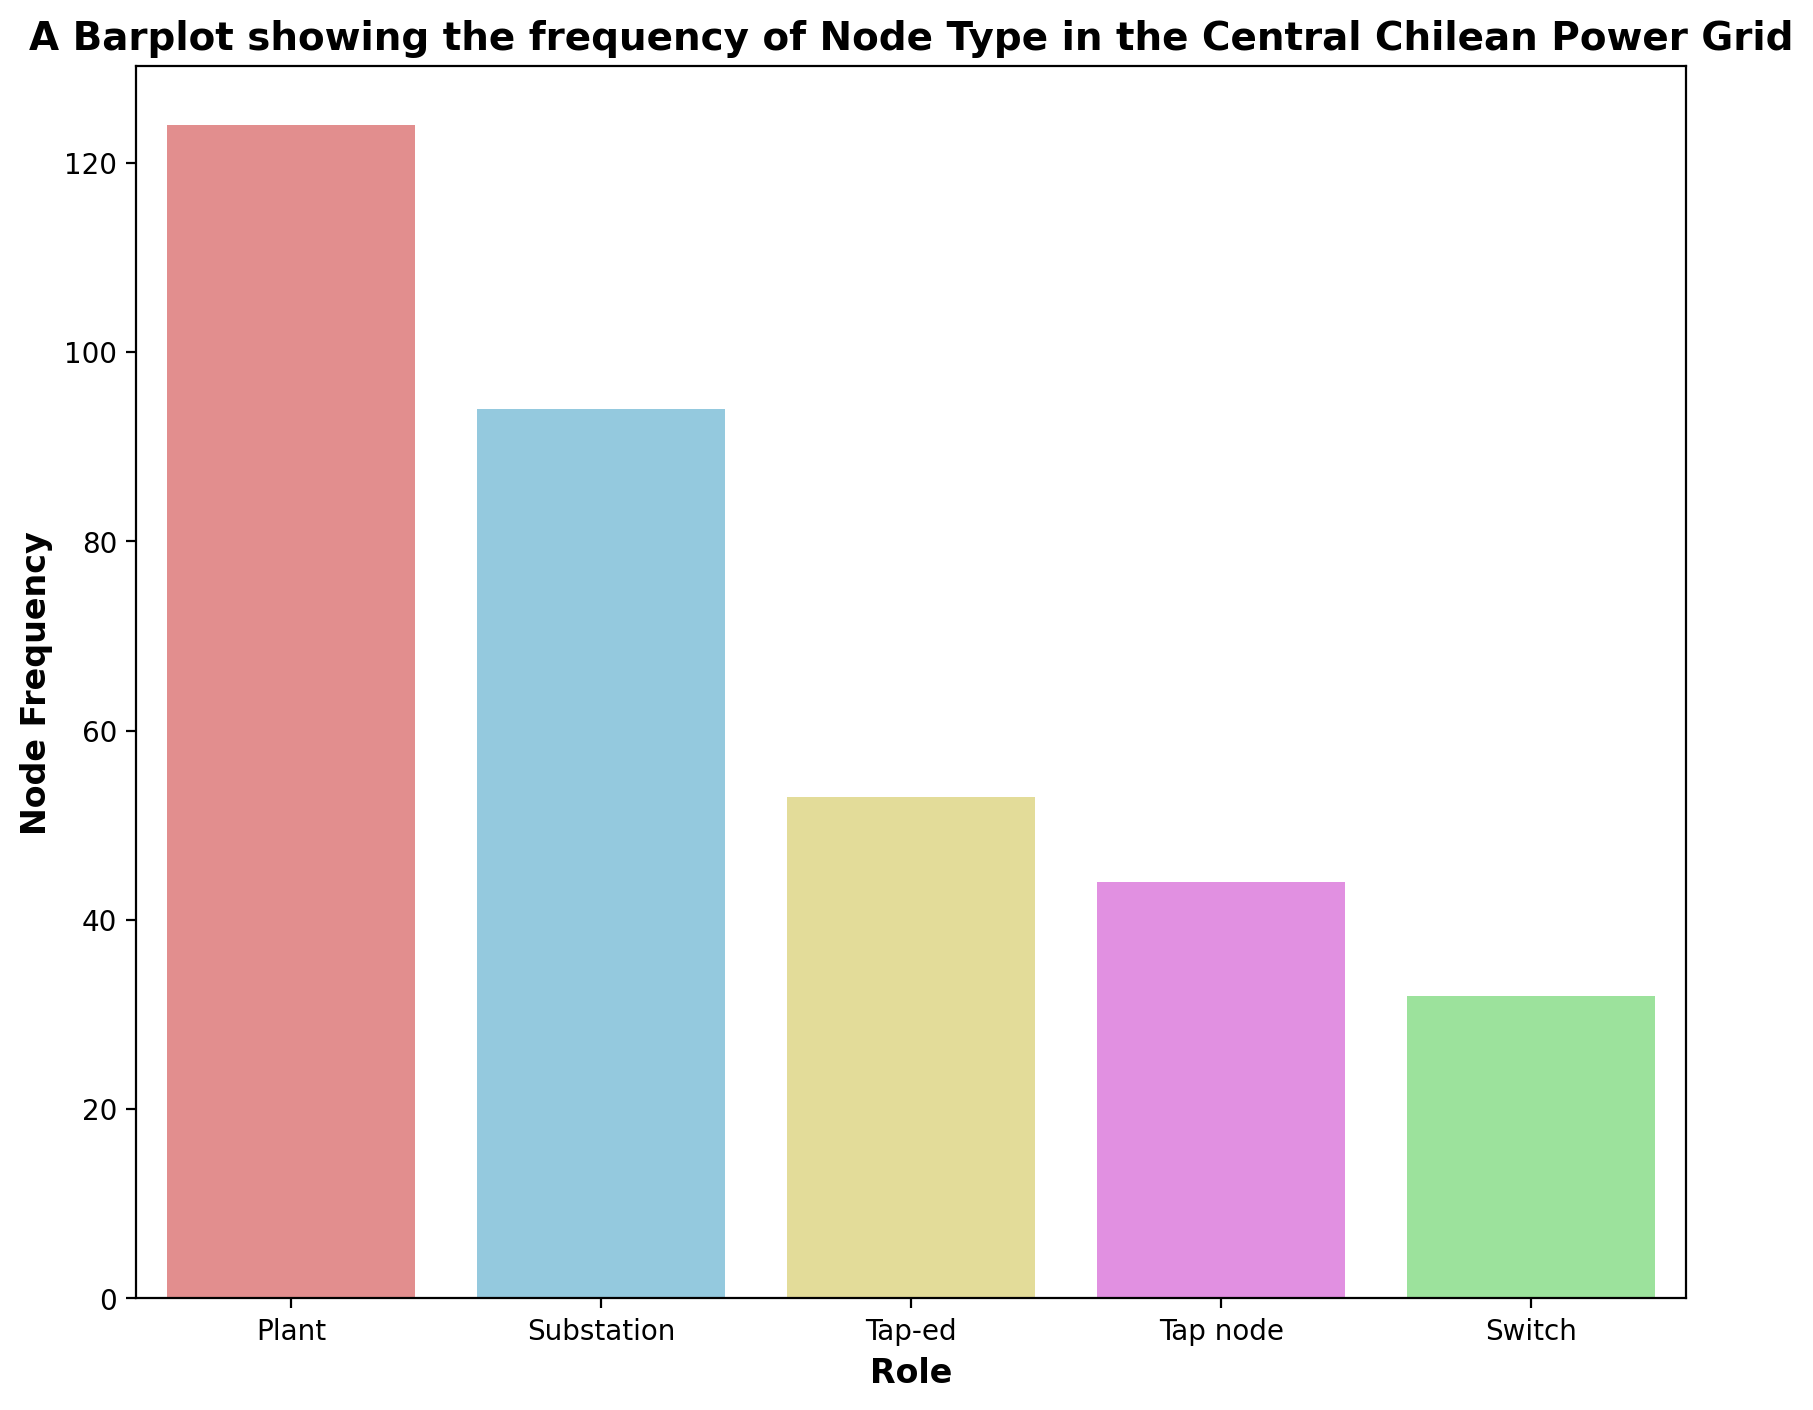

In [13]:
plt.figure(figsize=(10,8), dpi=200) # Setting figure size
plt.ylabel("Node Frequency", fontdict={'fontsize': 12, 'fontweight': 'bold'}) # Y-axis label
plt.xlabel("Type of Node", fontdict={'fontsize': 12, 'fontweight': 'bold'}) # X-axis label

# Confirm no null values under the Roles series
len(power_nodes) # 347
sum(power_nodes["Role"].notnull())

# Create Value counts of the Role Series
values = power_nodes["Role"].value_counts()

# Create the desired colour mapping
role_colours = {'Substation':'skyblue', 'Switch':'lightgreen', 'Plant':'lightcoral', 'Tap-ed':'khaki', 'Tap node':'violet'}

order = values.index

# Order the Colours to match with required bars
colour_palette = [role_colours[role] for role in order]

# Adding title and colours to the plot
plt.title("A Barplot showing the frequency of Node Type in the Central Chilean Power Grid", fontdict={'fontsize': 14, 'fontweight': 'bold'})
sns.barplot(y=values.values, x=order, palette=colour_palette)

# Saving barplot figure to include in our dataset explanation
plt.savefig("A Barplot showing the frequency of Node Type in the Central Chilean Power Grid");

**7. ISOLATE NUMBER OF NODES AND EDGES IN NETWORK**

*REFERENCED FROM CODE IN MA214-LAB-1*

In [14]:
# Print the number of nodes
print(f'number of nodes: {PowerGrid.number_of_nodes()}')

# Print the number of edges
print(f'number of edges: {PowerGrid.number_of_edges()}')

number of nodes: 347
number of edges: 444


**8. CALCULATE ADJACENCY MATRIX**

*REFERENCED FROM MA214-LAB-2*

In [15]:
# Create an adjacency matrix whilst enabling maximum display of node connections
np.set_printoptions(threshold=sys.maxsize) # Allows us to view the full adjacency matrix
A = nx.adjacency_matrix(PowerGrid)
print(A.todense())

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

**9. CONFIRM WHETHER NETWORK IS CYCLIC OR ACYCLIC**

*REFERENCED FROM MA214-LAB-2*

In [16]:
# Confirm whether the referenced network is cyclic or acyclic

nx.is_directed_acyclic_graph(PowerGrid)

False

**10. CALCULATE DENSITY OF NETWORK**

*REFERENCED FROM MA214-LAB-5*

In [17]:
# Print Density of "PowerGrid"
print(nx.density(PowerGrid))

# Find degree of PowerGrid Nodes
degree_powerGrid=PowerGrid.degree()

print(type(degree_powerGrid)) # - Confirm Type to show need for conversion
degree_powerGrid


0.007396178641035465
<class 'networkx.classes.reportviews.DegreeView'>


DegreeView({1: 3, 2: 3, 3: 1, 4: 3, 5: 1, 6: 12, 7: 1, 8: 1, 9: 3, 10: 3, 11: 5, 12: 3, 13: 1, 14: 2, 15: 1, 16: 3, 17: 4, 18: 3, 19: 1, 20: 3, 21: 5, 22: 1, 23: 6, 24: 1, 25: 3, 26: 1, 27: 3, 28: 3, 29: 5, 30: 3, 31: 3, 32: 3, 33: 3, 34: 5, 35: 3, 36: 1, 37: 2, 38: 3, 39: 3, 40: 4, 41: 3, 42: 2, 43: 7, 44: 1, 45: 3, 46: 3, 47: 1, 48: 3, 49: 1, 50: 3, 51: 2, 52: 3, 53: 5, 54: 7, 55: 1, 56: 2, 57: 1, 58: 1, 59: 1, 60: 3, 61: 3, 62: 3, 63: 4, 64: 4, 65: 3, 66: 3, 67: 4, 68: 3, 69: 3, 70: 2, 71: 3, 72: 6, 73: 3, 74: 3, 75: 1, 76: 3, 77: 3, 78: 4, 79: 2, 80: 1, 81: 5, 82: 3, 83: 2, 84: 1, 85: 3, 86: 3, 87: 2, 88: 3, 89: 3, 90: 4, 91: 2, 92: 2, 93: 5, 94: 3, 95: 2, 96: 3, 97: 3, 98: 3, 99: 4, 100: 5, 101: 5, 102: 1, 103: 7, 104: 3, 105: 6, 106: 2, 107: 4, 108: 24, 109: 3, 110: 1, 111: 3, 112: 3, 113: 1, 114: 3, 115: 3, 116: 3, 117: 4, 118: 2, 119: 2, 120: 2, 121: 4, 122: 4, 123: 3, 124: 1, 125: 3, 126: 1, 127: 1, 128: 1, 129: 1, 130: 4, 131: 3, 132: 1, 133: 3, 134: 1, 135: 1, 136: 4, 137: 4

**11. CALCULATE DEGREES, CLOSENESS AND BETWEENNESS OF NETWORK**

*REFERENCED FROM MA214-LAB-5 AND MA214-LAB-6*

In [18]:
# Creating dictionaries for each measure and printing thier outputs
degrees = dict(nx.degree(PowerGrid))
closeness = dict(nx.closeness_centrality(PowerGrid))
betweenness = dict(nx.betweenness_centrality(PowerGrid))
print("The degrees of each node:\n", degrees)
print('The closeness centrality of each node:\n', closeness)
print('The betweenness centrality of each node:\n', betweenness)

The degrees of each node:
 {1: 3, 2: 3, 3: 1, 4: 3, 5: 1, 6: 12, 7: 1, 8: 1, 9: 3, 10: 3, 11: 5, 12: 3, 13: 1, 14: 2, 15: 1, 16: 3, 17: 4, 18: 3, 19: 1, 20: 3, 21: 5, 22: 1, 23: 6, 24: 1, 25: 3, 26: 1, 27: 3, 28: 3, 29: 5, 30: 3, 31: 3, 32: 3, 33: 3, 34: 5, 35: 3, 36: 1, 37: 2, 38: 3, 39: 3, 40: 4, 41: 3, 42: 2, 43: 7, 44: 1, 45: 3, 46: 3, 47: 1, 48: 3, 49: 1, 50: 3, 51: 2, 52: 3, 53: 5, 54: 7, 55: 1, 56: 2, 57: 1, 58: 1, 59: 1, 60: 3, 61: 3, 62: 3, 63: 4, 64: 4, 65: 3, 66: 3, 67: 4, 68: 3, 69: 3, 70: 2, 71: 3, 72: 6, 73: 3, 74: 3, 75: 1, 76: 3, 77: 3, 78: 4, 79: 2, 80: 1, 81: 5, 82: 3, 83: 2, 84: 1, 85: 3, 86: 3, 87: 2, 88: 3, 89: 3, 90: 4, 91: 2, 92: 2, 93: 5, 94: 3, 95: 2, 96: 3, 97: 3, 98: 3, 99: 4, 100: 5, 101: 5, 102: 1, 103: 7, 104: 3, 105: 6, 106: 2, 107: 4, 108: 24, 109: 3, 110: 1, 111: 3, 112: 3, 113: 1, 114: 3, 115: 3, 116: 3, 117: 4, 118: 2, 119: 2, 120: 2, 121: 4, 122: 4, 123: 3, 124: 1, 125: 3, 126: 1, 127: 1, 128: 1, 129: 1, 130: 4, 131: 3, 132: 1, 133: 3, 134: 1, 135: 1

**12. Calculating Statistics for Centrality Measures**

*With the use of numpy functions* [33]

In [27]:

# Values were extracted from dictionaries and assigned to list for statistical calculations.

degree_values = list(degrees.values())
closeness_values = list(closeness.values())
betweenness_values = list(betweenness.values())

# Here, numpy functions were utilized to find the range, mean, and median for degrees, closeness, 
# and betweenness. 

degree_range = np.ptp(degree_values) # The np.ptp function was used to calculate the range.
degree_mean = np.mean(degree_values) # The np.mean function was used to calculate the mean. 
degree_median = np.median(degree_values) # The np.median function was used for calculating the median.

closeness_range = np.ptp(closeness_values)
closeness_mean = np.mean(closeness_values)
closeness_median = np.median(closeness_values)

betweenness_range = np.ptp(betweenness_values)
betweenness_mean = np.mean(betweenness_values)
betweenness_median = np.median(betweenness_values)


# Printing each calculations while clearly labelling each one. Ready for interpretation.

# Degree Statistics
print("Degree Range:", degree_range)
print("Degree Mean:", degree_mean)
print("Degree Median:", degree_median)

# Closeness Centrality Statistics
print("Closeness Centrality Range:", closeness_range)
print("Closeness Centrality Mean:", closeness_mean)
print("Closeness Centrality Median:", closeness_median)

# Betweennesss Centrality Statistics
print("Betweenness Centrality Range:", betweenness_range)
print("Betweenness Centrality Mean:", betweenness_mean)
print("Betweenness Centrality Median:", betweenness_median)

# The following Numpy statistical functions are from [33]

Degree Range: 23
Degree Mean: 2.559077809798271
Degree Median: 2.0
Closeness Centrality Range: 0.140535716508291
Closeness Centrality Mean: 0.128213498910954
Closeness Centrality Median: 0.12791127541589647
Betweenness Centrality Range: 0.6007642467833493
Betweenness Centrality Mean: 0.020739526124062956
Betweenness Centrality Median: 0.005780346820809248


**13. Histogram plot for Centrality measures**

*With the use of matplotlib* [38]

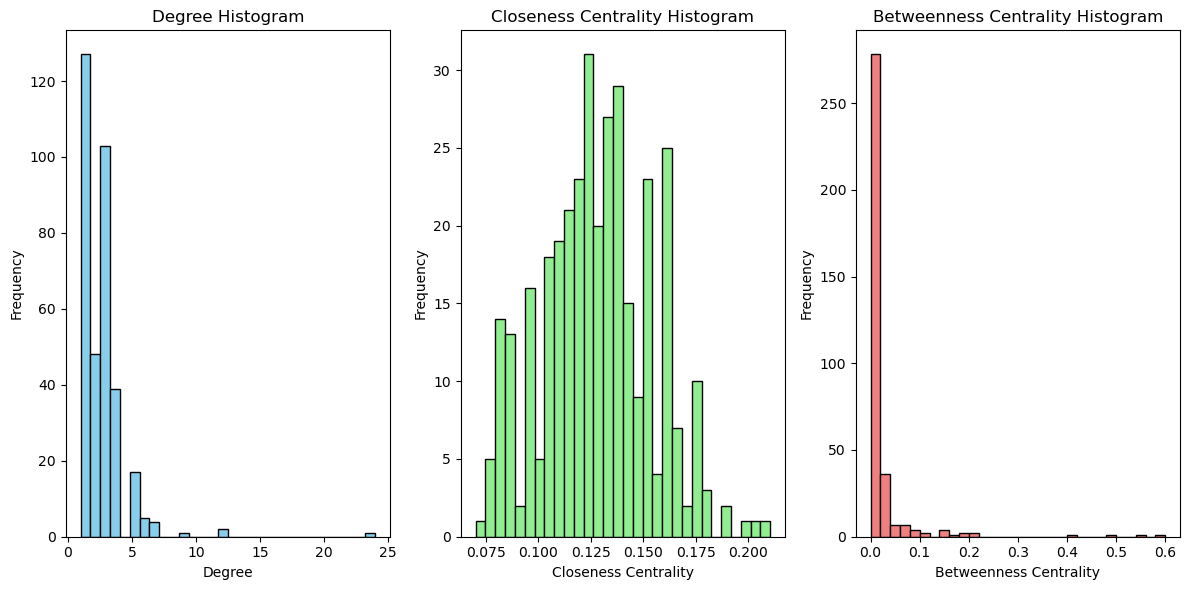

In [20]:

# Histograms for Degree, Closeness Centrality, Betweenness Centrality

plt.figure(figsize=(12, 6)) # Plotting figure size

# Plotting Degree Histogram. Creating three subplot to show all three histograms in one figure.
plt.subplot(1, 3, 1) # Creating a subplot to add to our main figure
plt.hist(list(degrees.values()), bins=30, color='skyblue', edgecolor='black') # Plotting histogram with aesthetics
# Set the bins to 30 so we can clearly see the distribution across the X axis
plt.title('Degree Histogram') # Adding title
plt.xlabel('Degree') # Adding X axis label
plt.ylabel('Frequency') # Adding Y axis label

# Plotting closeness centrality histogram
plt.subplot(1, 3, 2) # Creating a subplot to add to our main figure
plt.hist(list(closeness.values()), bins=30, color='lightgreen', edgecolor='black') # Plotting histogram with aesthetics
plt.title('Closeness Centrality Histogram') # Adding title
plt.xlabel('Closeness Centrality') # Adding X axis label
plt.ylabel('Frequency') # Adding Y axis label

# Plotting betweenness centrality histogram
plt.subplot(1, 3, 3) # Creating a subplot to add to our main figure
plt.hist(list(betweenness.values()), bins=30, color='lightcoral', edgecolor='black') # Plotting histogram with aesthetics
plt.title('Betweenness Centrality Histogram') # Adding title
plt.xlabel('Betweenness Centrality') # Adding X axis label
plt.ylabel('Frequency') # Adding Y axis label

plt.tight_layout() # Adjusting layout for a clearer image

# Saving  figure and using bbox_inches to control the image proportions.
plt.savefig('Degreemclosenessbetweenness.png', bbox_inches='tight') 

plt.show() # Displaying plot

# The following histograms were created using the following [38].

**14. IDENTIFY NODE TYPE FOR MAXIMAL CENTRALITY NODE**

In [21]:
print(power_nodes.head())
print(edges.head())
print(power_nodes["Role"].unique())

# Identify Node type for Maximal Centrality Node
print(power_nodes.iloc[107])
print(power_nodes.iloc[177])

   Id           Label                  Owner        Role  Longitude  \
0   1      San Javier               Transnet  Substation -71.711721   
1   2    Constitucion               Transnet  Substation -72.402716   
2   3          Paposo              Transelec      Switch -69.943670   
3   4  Tap Off Taltal  Electrica Panguipulli      Switch -69.943670   
4   5   Eolica Taltal             P.E Taltal       Plant -69.848464   

    Latitude        ref  
0 -35.588740   original  
1 -35.363701   original  
2 -25.730608  converted  
3 -25.730608  converted  
4 -25.059477   original  
   Source  Target        Type  Distance  Voltage  Lines
0       1       2  Undirected     75.13       66      1
1       3       4  Undirected     20.00      220      2
2       4       5  Undirected     43.00      220      1
3       4       6  Undirected    165.00      220      2
4       6       7  Undirected      0.00      110      1
['Substation' 'Switch' 'Plant' 'Tap-ed' 'Tap node']
Id                  108
Label

**15. THE TOP 10 NODES FOR CLOSENESS CENTRALITY**

In [23]:
# A Breakdown of the top 10 Nodes for Closeness Centrality
# Convert NX object to dict format
closeness = nx.closeness_centrality(PowerGrid)

# Sort nodes by closeness centrality
sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)
# Create a list using comprehension that creates nested lists comprised of the node index and related centrality

top_closeness = [[node ,round(value, 4)] for node, value in sorted_closeness[0:10]]
print(top_closeness)


# Isolate the Index of the Top 10 Closeness Nodes

top_closeness_index = [idx - 1 for idx, cent in top_closeness]

# Generate Type of node for Top Closeness Centralities via DF ILOC:
power_nodes.iloc[top_closeness_index][["Id", "Role"]].set_index("Id")[0:10]

[[178, 0.2106], [105, 0.2057], [147, 0.197], [108, 0.1912], [183, 0.1891], [67, 0.1789], [219, 0.1784], [186, 0.1783], [218, 0.1776], [220, 0.1765]]


,Role
Id,
178,Substation
105,Substation
147,Substation
108,Substation
183,Tap-ed
67,Substation
219,Tap node
186,Substation
218,Tap node


**16. THE TOP 10 NODES FOR BETWEENNESS CENTRALITY**

In [25]:
# A Breakdown of the top 10 Nodes for Betweenness Centrality

betweenness = nx.betweenness_centrality(PowerGrid)

# Sort nodes by betweenness 
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)


top_betweenness = [[node ,round(value, 4)] for node, value in sorted_betweenness[0:10]]
print(top_betweenness)

# Isolate the Index of the Top 10 Betweenness Nodes

top_betweenness_index = [idx - 1 for idx, cent in top_betweenness]

# Generate Type of node for Top Betweenness Centralities via DF ILOC:
power_nodes.iloc[top_betweenness_index][["Id", "Role"]].set_index("Id")[0:10]

[[178, 0.6008], [105, 0.5539], [108, 0.5002], [147, 0.4142], [136, 0.2197], [130, 0.205], [43, 0.198], [295, 0.1899], [308, 0.1666], [100, 0.1597]]


,Role
Id,
178,Substation
105,Substation
108,Substation
147,Substation
136,Switch
130,Substation
43,Substation
295,Substation
308,Substation


**17. SHARED NODES WITHIN TOP 10 OF BOTH BETWEENNESS AND CLOSENESS CENTRALITY**

In [24]:
# Identify shared nodes within top 10 of both betweenness and closeness centrality


# Reset Index for top_betweenness and top_closeness

top_betweenness_index =  [idx for idx, cent in top_betweenness]
top_closeness_index = [idx for idx, cent in top_closeness]

print("Top betweenness index:",top_betweenness_index); print("Top closeness index:", top_closeness_index)

#Find common items
common_elements = list(set(top_betweenness_index) & set(top_closeness_index))

print("Column elements found in both top 10 CC & BC Measures are: {}".format(common_elements))


Top betweenness index: [178, 105, 108, 147, 136, 130, 43, 295, 308, 100]
Top closeness index: [178, 105, 147, 108, 183, 67, 219, 186, 218, 220]
Column elements found in both top 10 CC & BC Measures are: [105, 178, 147, 108]


**18. IDENTIFY OUTLIERS FOR BETWEENNESS CENTRALITY**

In [25]:
betweenness = nx.betweenness_centrality(PowerGrid)

betweenness_values = list(betweenness.values())
betweenness_values

betweenness_values = list(betweenness.values())

# Calculate Q1 and Q3
Q1 = np.percentile(betweenness_values, 25)
Q3 = np.percentile(betweenness_values, 75)

# GET IQR
IQR = Q3 - Q1

# Set Bounds for Outside IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = [[node, centrality] for node, centrality in betweenness.items() 
                       if centrality < lower_bound or centrality > upper_bound]

# Sorting the nodes within bounds by their centrality values in descending order
sorted_outliers = sorted(outliers, key=lambda x: x[1], reverse=True)

sorted_outliers


[[178, 0.6007642467833493],
 [105, 0.5539290256530769],
 [108, 0.500229830346694],
 [147, 0.4141625677664882],
 [136, 0.2197326041080753],
 [130, 0.20496383792689396],
 [43, 0.19804417637038899],
 [295, 0.1899220909776323],
 [308, 0.16659127083856917],
 [100, 0.15969283181145458],
 [309, 0.15447208958141356],
 [21, 0.15295360164674063],
 [54, 0.14162687442405966],
 [23, 0.10506827511099942],
 [103, 0.10071750064461764],
 [67, 0.0872725858375514],
 [317, 0.08490687219010917],
 [123, 0.08473039010359945],
 [125, 0.08473039010359945],
 [6, 0.0764932562620424],
 [183, 0.07244667259243762],
 [121, 0.0713891581597035],
 [219, 0.06585047690853174],
 [72, 0.06405414138512906],
 [53, 0.06137835468823186],
 [81, 0.06063551901450896],
 [182, 0.05839821762666694],
 [160, 0.057496300019547045],
 [320, 0.05561419675518695],
 [20, 0.050024294211275855],
 [17, 0.04555583479936332],
 [220, 0.043024210438133544],
 [64, 0.04031761988535049],
 [184, 0.039928252474118096],
 [144, 0.039160553221875165],
 [1

**19. FINDING WINSORIZED MEAN TO FURTHER ANALYSE THE CENTRALITY MEASURES**


*With the use of Scipy and Numpy functions* [35][33].

In [ ]:

#Convert the centrality measures to arrays
degrees_array = np.array(list(degrees.values()))
closeness_array = np.array(list(closeness.values()))
betweenness_array = np.array(list(betweenness.values()))

#Winsorize the centrality measures
winsorized_degrees = winsorize(degrees_array, limits=[0.10, 0.10])
winsorized_closeness = winsorize(closeness_array, limits=[0.10, 0.10])
winsorized_betweenness = winsorize(betweenness_array, limits=[0.10, 0.10])

#Calculate the mean of winsorized centrality measures
mean_winsorized_degrees = round(np.mean(winsorized_degrees), 4)
mean_winsorized_closeness = round(np.mean(winsorized_closeness), 4)
mean_winsorized_betweenness = np.mean(winsorized_betweenness)

#Print the mean winsorized centrality measures
print("Mean winsorized degrees:", mean_winsorized_degrees)
print('Mean winsorized closeness centrality:', mean_winsorized_closeness)
print('Mean winsorized betweenness centrality:', mean_winsorized_betweenness)

# The winsorize function was sourced from the following [35].
# The numpy functions [33].

**20. CALCULATE LOCAL CLUSTERING COEFFICIENT**

*CLUSTERING COEFFICIENCY CODE - REFERENCED FROM MA214-LAB-7*

In [20]:
cluster_coef = nx.clustering(PowerGrid, nodes=None, weight=None)

In [21]:
# Calculate the mean, std deviation, median and range of the local clustering coefficients.
mean = st.mean(cluster_coef.values())
median = st.median(cluster_coef.values())
std = st.stdev(cluster_coef.values())

# Calculate Range

min = min(cluster_coef.values())
max = max(cluster_coef.values())


print("The mean of the Clustering Coefficient is: {}".format(mean))
print("The median of the Clustering Coefficient is: {}".format(median))
print("The Standard Deviation of the Clustering Coefficient is: {}".format(std))
print("The Range of the Clustering Coefficient is: {}".format(max-min))

The mean of the Clustering Coefficient is: 0.08650192475527646
The median of the Clustering Coefficient is: 0
The Standard Deviation of the Clustering Coefficient is: 0.20639035080388077
The Range of the Clustering Coefficient is: 1.0


**21. PLOT HISTOGRAM FOR CLUSTERING COEFFICIENTS**

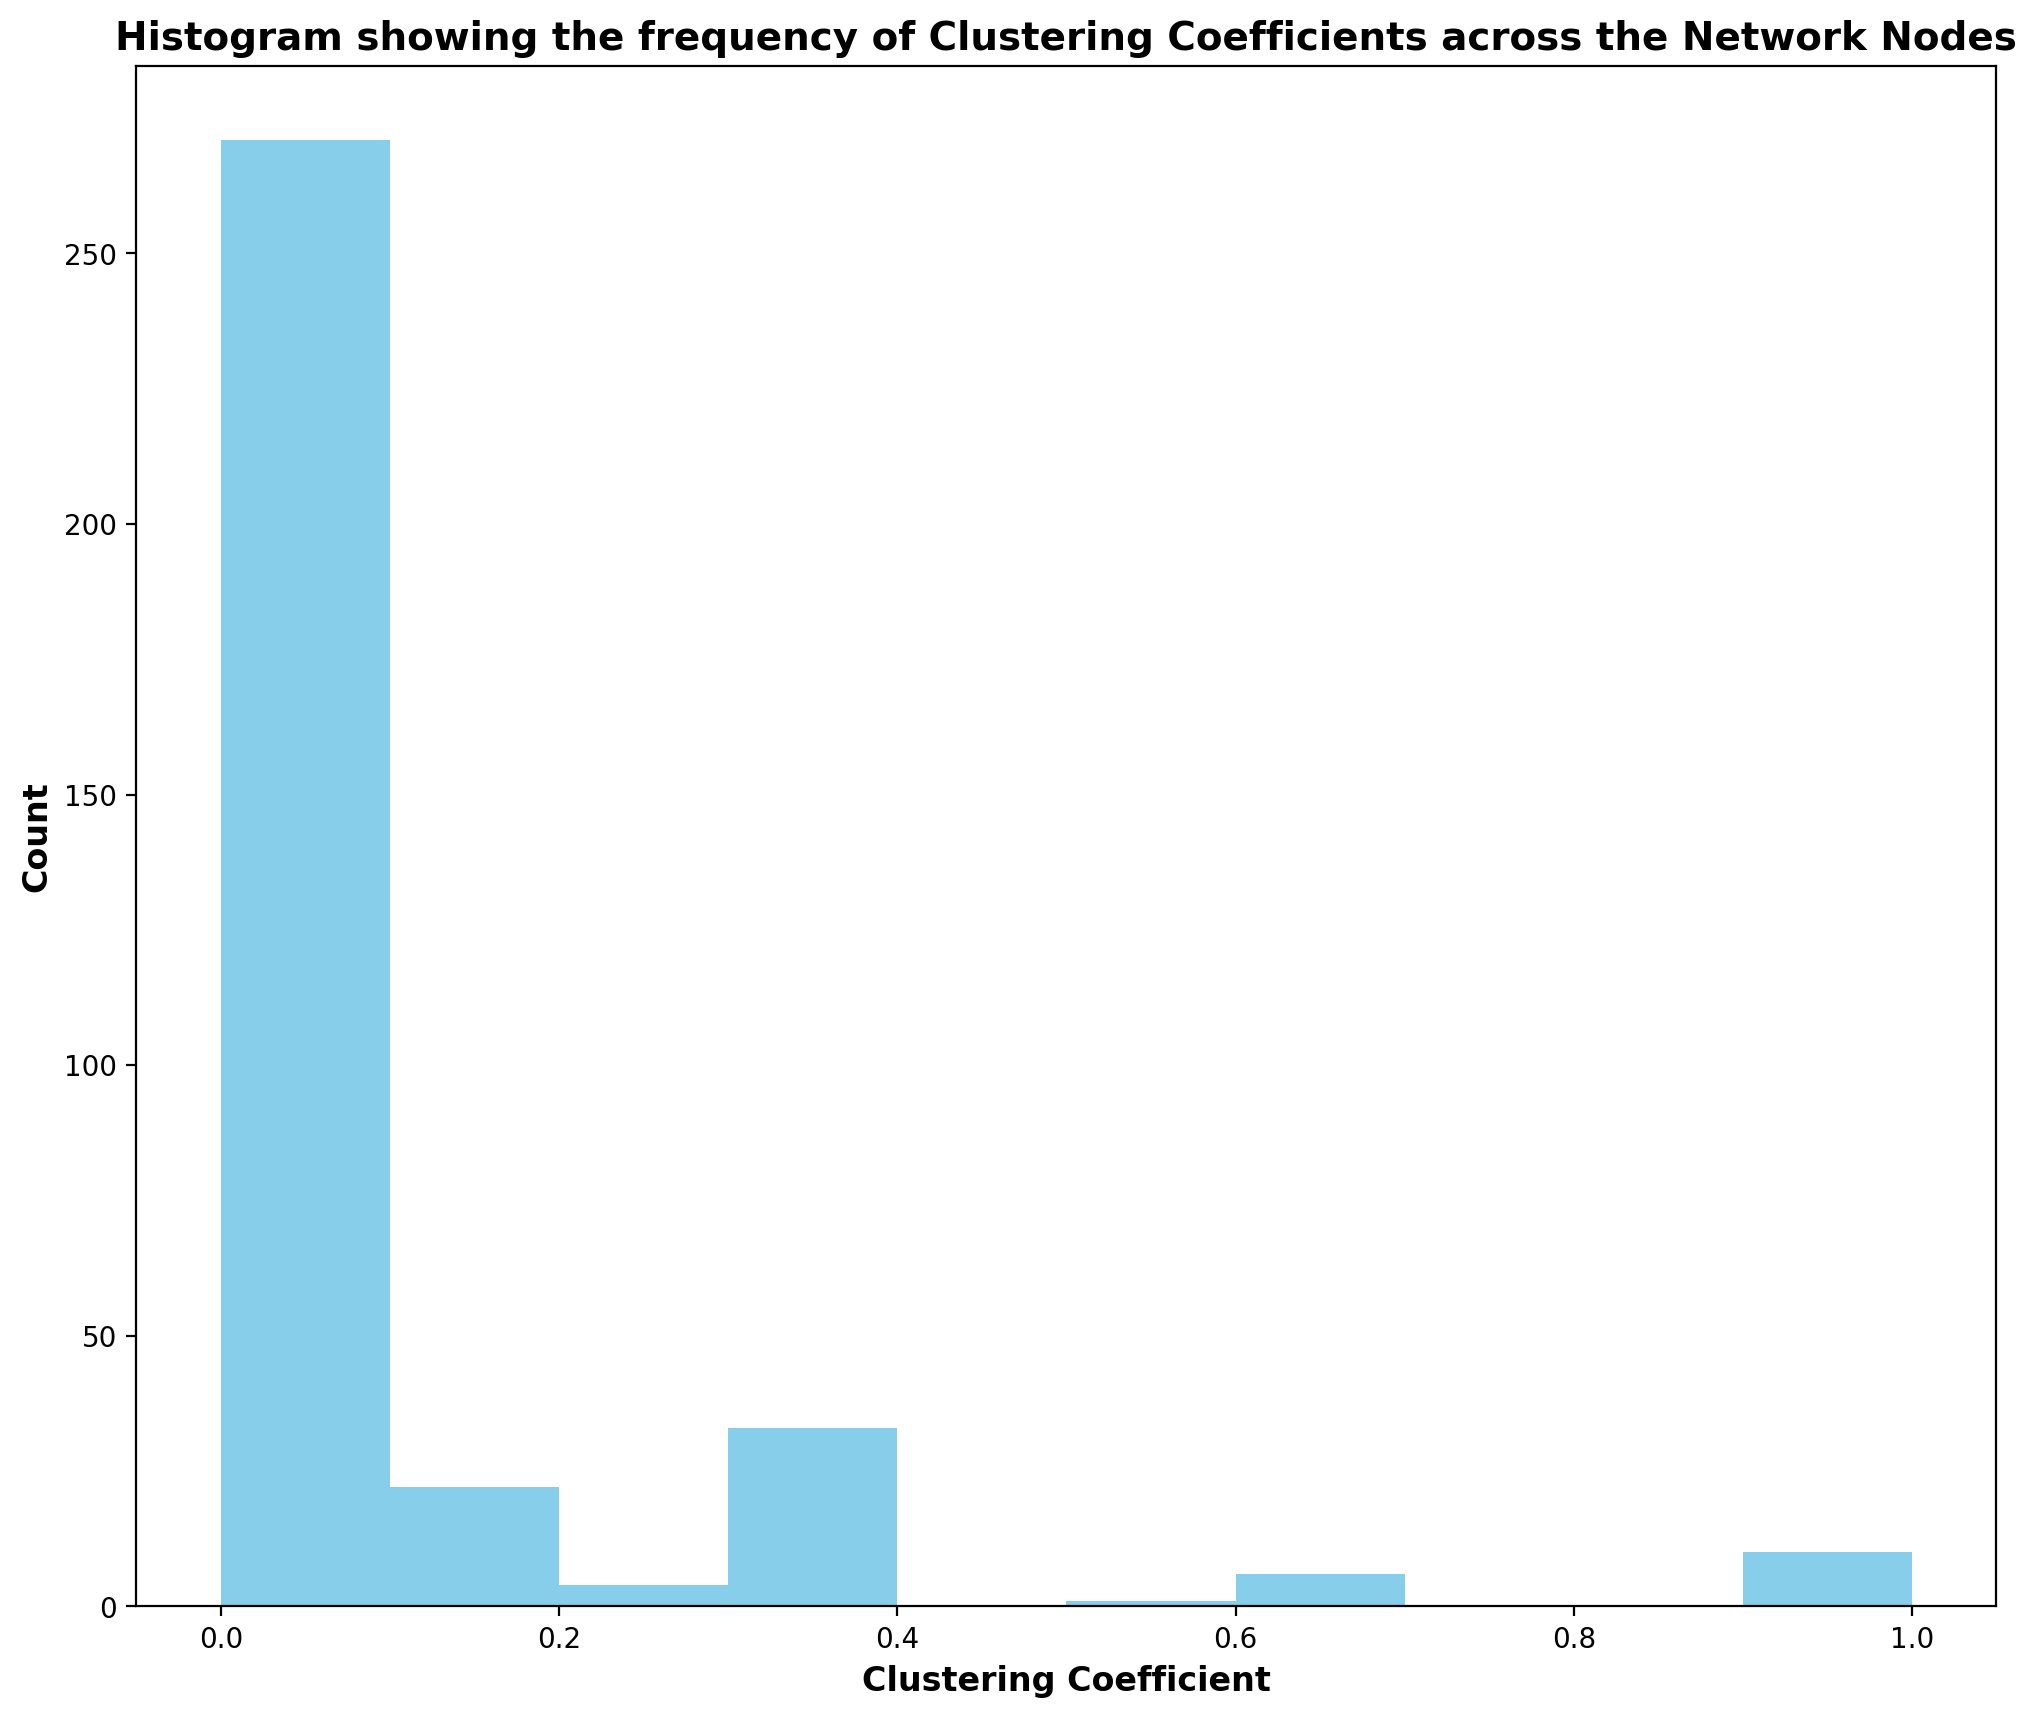

In [35]:
plt.figure(figsize = (12,10), dpi=200) # Plotting figure size and and image resolution

plt.hist(cluster_coef.values(), density=False, bins=10, color = 'skyblue') # Plotting histogram

plt.xlabel("Clustering Coefficient", fontdict={'fontsize': 12, 'fontweight': 'bold'}) # X-axis labels

plt.ylabel("Count", fontdict={'fontsize': 12, 'fontweight': 'bold'}) # Y-axis label

# Plotting title
plt.title("Histogram showing the frequency of Clustering Coefficients across the Network Nodes", fontdict={'fontsize': 14, 'fontweight': 'bold'})

# Saving figure for analysis
plt.savefig("Histogram showing the frequency of Clustering Coefficients across the Network Nodes");

**22. MODULARITY**

*REFERENCED FROM MA214-PGT-Lecture-2*

The partition that maximize the modularity:  [frozenset({261, 262, 263, 264, 265, 18, 19, 281, 282, 283, 284, 285, 29, 286, 288, 289, 287, 290, 291, 292, 293, 295, 296, 297, 294, 298, 299, 45, 302, 301, 46, 303, 304, 307, 337, 108, 113, 114, 117, 118, 119, 120}), frozenset({9, 10, 16, 17, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 336, 346}), frozenset({65, 130, 66, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 20, 21, 344, 90, 169, 170, 171, 172, 121, 122, 59, 60, 61, 62}), frozenset({192, 193, 72, 201, 202, 73, 76, 77, 78, 207, 81, 82, 212, 85, 86, 213, 87, 214, 88, 218, 219, 222, 39, 178, 180, 181, 182, 186, 189, 190, 191}), frozenset({11, 335, 93, 221, 223, 224, 225, 226, 94, 95, 96, 97, 98, 34, 35, 99, 103, 104, 235, 236, 237, 238, 239, 240, 241, 242, 243, 247, 248}), frozenset({260, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 340, 277, 278, 280, 279,

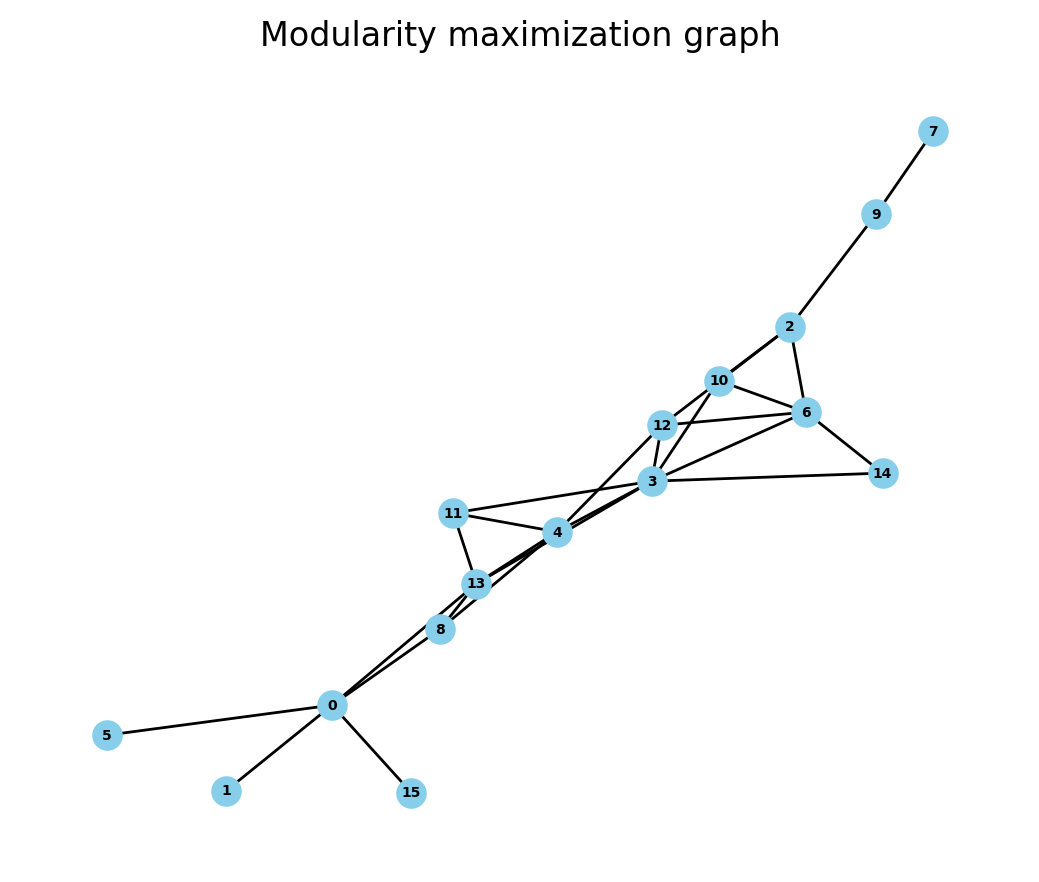

In [26]:
# Greedy_modularity_communities
# FROM MA214 PGT lecture 2


# We are looking to maximise modularity

# we use the greedy modularity algorithm creating communities in the variable 'parition'
partition=list(nx_comm.greedy_modularity_communities(PowerGrid))
print("The partition that maximize the modularity: ", partition)

# next calculate the maximum modularity from the partition above
max_modularity=nx_comm.modularity(PowerGrid,partition)
print("The maximum modularity is ", max_modularity)

# create two new variables to store the lengths of our new partitions and our original nodes
partition_groups = len(partition)
original_nodes = len(PowerGrid.nodes())

# Print the new partitions 
print(f'New Groups: {partition_groups}')

# Print the original nodes
print(f'Original nodes: {original_nodes}')

# We have found that the new graph will consist of 16 nodes/communities.

# Finding all the neighbours of the nodes in each community
neighbors=[] # empty list used for storage of neighbors from our for loops below
for i in range(0,len(partition)): # For loop scrub through the partition storing any neighbors in our blank list above
    neighbors.append(set()) # add empty set to neighbors

for i in range(0, len(partition)): # For loop scrub through the partition storing any neighbors in our blank list above
    for j in range(0, len(partition[i])):  
        neighbors[i]=neighbors[i].union(set(PowerGrid.neighbors(list(partition[i])[j]))) 


# Create an indicator for each community.
        Indicator=[] # another empty list to store new indicators from our for loops below 
for i in range(0,len(partition)): #for loops used to scrub each community finding indicator values. then storing in blank list above
    Indicator.append([]) 
    
for i in range(0, len(partition)): # we are using the neighbours of nodes in community i
    for j in range(0, len(partition)): # that are located in community j
        Indicator[i].append(len(neighbors[i].intersection(partition[j])))

# Here, we are creating a list of nodes for the new communities we have created above
        nodeslist=list(range(0,len(partition)))
edgeslist=[] #create a blank list for our edges above
for i in range(0,len(partition)): ## for loop used to scrub through our partitions and find indicators that are !=0 adding them to the edge list
    for j in range(i+1,len(partition)):
        if Indicator[i][j]!=0:
            edgeslist.append((i,j))

#plot the figure from the above edges and nodes
plt.figure(figsize=(5,4), dpi=200)

G=nx.Graph() # Create a blank network graph
G.add_nodes_from(nodeslist) # Add the nodes to the network
G.add_edges_from(edgeslist) # Add the edges to the network

#  create labels, pick a colour scheme, add definition to the numbers/nodes
nx.draw(G,with_labels=True, node_color = 'skyblue', font_weight='bold', node_size = 100, font_size = 5)

# Add a title
plt.title('Modularity maximization graph');

# Save the figures
plt.savefig('Modularity maximization graph.png')

print("We have created 16 nodes, which are distinct groups of nodes.\nWe have separated the network in 4 communities/networks.\nNot many edges between communities. Partition is bad")


**23. CODE FILE REFERENCES:**

*Also provided in our references section*

33.
Harris CR, Millman KJ, van der Walt SJ, Gommers R, Virtanen P, Cournapeau D, et al. 
Array programming with NumPy. Nature. 
Available from: https://numpy.org/doc/stable/reference/routines.statistics.html  


34.
basemap 1.4.1 documentation. matplotlib.org. 
Available from: https://matplotlib.org/basemap/stable/index.html#welcome-to-the-basemap-documentation  

35.
 Virtanen P, Gommers R, Oliphant TE, Haberland M, Reddy T, Cournapeau D, et al. 
 SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods. 2020;17:261–72. 
 Available from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html  
 
 36.
Tutorial — NetworkX 2.5 documentation [Internet]. networkx.org. 
Available from: https://networkx.org/documentation/stable/tutorial.html  

37.
sys — System-specific parameters and functions — Python 3.7.3 documentation [Internet]. Python.org. 2010. 
Available from: https://docs.python.org/3/library/sys.html  

38.
matplotlib.pyplot.hist — Matplotlib 3.5.1 documentation [Internet]. matplotlib.org. 
Available from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

39.
matplotlib.patches.Patch — Matplotlib 3.5.2 documentation [Internet]. matplotlib.org. Available from: https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html
